# Deep learning in Human Language Technology Project

- Student(s) name(s): Abhishek Roy , Shaktiman Choudhury
- Date: 31.01.2026
- Contributions : Abhishek handled notebook setup, dataset preprocessing and training pipeline creation.
Shaktiman read related works, executed the training, evaluated the results and performed error analysis.
- ##### Chosen Corpus: IMDB Dataset

---

## 1. Setup

In [1]:
![ "$COLAB_RELEASE_TAG" ] && pip3 -q install datasets transformers evaluate

In [2]:
# pip install transformers datasets evaluate accelerate torch matplotlib scikit-learn

In [3]:
import transformers
import datasets
import random
import torch
import evaluate
from collections import defaultdict
from pprint import pprint
import matplotlib.pyplot as plt
random.seed(42)

transformers.logging.enable_progress_bar()  
transformers.logging.set_verbosity_warning()

/home/scp619/HLT/Project_SCP/hlt_project/.venv/lib/python3.14/site-packages/multiprocess/connection.py:335: SyntaxWarning: 'return' in a 'finally' block
  return f
/home/scp619/HLT/Project_SCP/hlt_project/.venv/lib/python3.14/site-packages/multiprocess/connection.py:337: SyntaxWarning: 'return' in a 'finally' block
  return self._get_more_data(ov, maxsize)


In [4]:
transformers 

<module 'transformers' from '/home/scp619/HLT/Project_SCP/hlt_project/.venv/lib/python3.14/site-packages/transformers/__init__.py'>

### 1.1. Models

The models being used for this project are as follows:
* Bidirectional model: [google-bert/bert-base-cased](https://huggingface.co/google-bert/bert-base-cased)
* Generative model: [HuggingFaceTB/SmolLM-135M-Instruct](https://huggingface.co/HuggingFaceTB/SmolLM-135M-Instruct)

In [5]:
BERT = "bert-base-cased"
SMOLLM = "HuggingFaceTB/SmolLM-135M-Instruct"

---

## 2. Data download, sampling and preprocessing



### 2.1. Download the corpus

For this, we are using the IMDB dataset, loaded in using the `datasets.load_dataset` API

In [6]:
imdb_dataset = datasets.load_dataset("stanfordnlp/imdb")
del imdb_dataset["unsupervised"]
imdb_dataset = imdb_dataset.shuffle(seed=42)
imdb_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
})

In [7]:
imdb_dataset["train"].features

{'text': Value('string'), 'label': ClassLabel(names=['neg', 'pos'])}

In [8]:
pprint(imdb_dataset['test'][0])

{'label': 1,
 'text': '<br /><br />When I unsuspectedly rented A Thousand Acres, I thought '
         'I was in for an entertaining King Lear story and of course Michelle '
         'Pfeiffer was in it, so what could go wrong?<br /><br />Very quickly, '
         'however, I realized that this story was about A Thousand Other '
         "Things besides just Acres. I started crying and couldn't stop until "
         'long after the movie ended. Thank you Jane, Laura and Jocelyn, for '
         'bringing us such a wonderfully subtle and compassionate movie! Thank '
         'you cast, for being involved and portraying the characters with such '
         'depth and gentleness!<br /><br />I recognized the Angry sister; the '
         'Runaway sister and the sister in Denial. I recognized the Abusive '
         'Husband and why he was there and then the Father, oh oh the '
         'Father... all superbly played. I also recognized myself and this '
         'movie was an eye-opener, a relief

In [9]:
def assign_label_names(example):
    label_names = ["negative", "positive"]
    example["label_name"] = label_names[example["label"]]
    return example

imdb_dataset = imdb_dataset.map(assign_label_names)
imdb_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'label_name'],
        num_rows: 25000
    })
})

In [10]:
pprint(imdb_dataset['test'][0])

{'label': 1,
 'label_name': 'positive',
 'text': '<br /><br />When I unsuspectedly rented A Thousand Acres, I thought '
         'I was in for an entertaining King Lear story and of course Michelle '
         'Pfeiffer was in it, so what could go wrong?<br /><br />Very quickly, '
         'however, I realized that this story was about A Thousand Other '
         "Things besides just Acres. I started crying and couldn't stop until "
         'long after the movie ended. Thank you Jane, Laura and Jocelyn, for '
         'bringing us such a wonderfully subtle and compassionate movie! Thank '
         'you cast, for being involved and portraying the characters with such '
         'depth and gentleness!<br /><br />I recognized the Angry sister; the '
         'Runaway sister and the sister in Denial. I recognized the Abusive '
         'Husband and why he was there and then the Father, oh oh the '
         'Father... all superbly played. I also recognized myself and this '
         'movie 

### 2.2. Sampling and preprocessing

Take 6000 samples from the train set from which 1000 samples will become validation set. Take 1000 samples from test set. In all of these cases, sampling will be stratified for equal distribution.

In [11]:
train_neg_data_indices = [i for i, label in enumerate(imdb_dataset["train"]["label"]) if label == 0]
train_pos_data_indices = [i for i, label in enumerate(imdb_dataset["train"]["label"]) if label == 1]

test_neg_data_indices = [i for i, label in enumerate(imdb_dataset["test"]["label"]) if label == 0]
test_pos_data_indices = [i for i, label in enumerate(imdb_dataset["test"]["label"]) if label == 1]

sampled_train_indices = random.sample(train_neg_data_indices, 3000) + random.sample(train_pos_data_indices, 3000)
sampled_test_indices = random.sample(test_neg_data_indices, 500) + random.sample(test_pos_data_indices, 500)

sampled_train_dataset = imdb_dataset["train"].select(sampled_train_indices)
sampled_test_dataset = imdb_dataset["test"].select(sampled_test_indices)

sampled_train_test_split = sampled_train_dataset.train_test_split(test_size=1000, seed=42, stratify_by_column="label")

sampled_dataset = datasets.DatasetDict({
    "train": sampled_train_test_split["train"],
    "val": sampled_train_test_split["test"],
    "test": sampled_test_dataset,
})

sampled_dataset = sampled_dataset.shuffle(seed=42)

In [12]:
for k in sampled_dataset.keys():
    print(f'{k} set neg: {sampled_dataset[k]["label"].count(0)} pos: {sampled_dataset[k]["label"].count(1)}')

train set neg: 2500 pos: 2500
val set neg: 500 pos: 500
test set neg: 500 pos: 500


---

## 3. Prompting a generative model

### 3.1 Prompt optimization

#### 3.1.1 Prompt Setup

In [13]:
INSTRUCTION = 'You are a sentiment classifier. Analyze movie reviews and classify them as either "positive" or "negative". Only reply with  "positive" or "negative". Do not include any additional texts. Do not use any capital caracters.' 

In [14]:
def get_truncated_text(text, limit):
    words = text.split()
    limit = min(len(words), limit)
    return " ".join(words[:limit])
    

def get_x_shot_prompt(text, examples, max_text_tokens):
    prompt = f'{INSTRUCTION}\n'
    
    if len(examples) > 0:
        prompt += "\nExamples:\n"
        for example in examples:
            truncated_text = get_truncated_text(example['text'], max_text_tokens)
            prompt += f"\nReview: {truncated_text}\nSentiment: {example['label_name']}\n"
    
    prompt += f"""
Now classify this review:

Review: {get_truncated_text(text, max_text_tokens)}
Sentiment:"""
    
    return prompt

#### 3.1.2 Generate Pipeline

Using `transformers.pipeline` to get a text-generation pipeline using this model. For this we are going with [HuggingFaceTB/SmolLM-135M-Instruct](https://huggingface.co/HuggingFaceTB/SmolLM-135M-Instruct) model.

In [15]:

text_gen_pipeline_SmolLM = transformers.pipeline(
    "text-generation",
    model=SMOLLM,
    dtype=torch.float16,
    device_map=0
)

Device set to use cuda:0


#### 3.1.3 Generate prompts

We will be using 4-shot prompt for evaluating the model.

In [16]:
examples = [
    sampled_dataset["train"]["label"].index(0),
    sampled_dataset["train"]["label"].index(1)
]
examples.extend([
    sampled_dataset["train"]["label"].index(0, examples[0]+1),
    sampled_dataset["train"]["label"].index(1, examples[1]+1)
]) 

examples = sampled_dataset["train"].select(examples)

examples["label"]

Column([0, 1, 0, 1])

In [17]:
get_four_shot_prompt = lambda x: get_x_shot_prompt(
    x,
    examples,
    text_gen_pipeline_SmolLM.tokenizer.model_max_length - 100
)

prompts = list(map(get_four_shot_prompt, sampled_dataset["test"]["text"][:]))

print(prompts[0])

You are a sentiment classifier. Analyze movie reviews and classify them as either "positive" or "negative". Only reply with  "positive" or "negative". Do not include any additional texts. Do not use any capital caracters.

Examples:

Review: Overall an extremely disappointing picture. Very, very slow build up to the basic storyline. The role of Maria Schrader searching for her families secret past. (Every take seems to last forever . There is really no rhythm in the film.) ***SPOILERS*** Her Mother Ruth is rescued from the Nazis, by a German woman, played by Katja Riemann. The entire character of Ruth is so one dimensional, so stereotypical. ***SPOILERS END*** The film cuts back and forth between present day New York and Berlin and Berlin 40s something. Please when you do that, give the audience an indication of what time exactly the story takes place. There is never a clear indication of time  very annoying. Worst part is, the end. ***SPOILERS*** The entire show and jabber about the 

### 3.2 Evaluation on test set

In [18]:
responses = text_gen_pipeline_SmolLM(
    prompts,
    do_sample=False,
    max_new_tokens=1,
    temperature=0.1,
    pad_token_id=text_gen_pipeline_SmolLM.tokenizer.eos_token_id
)

responses = list(map(lambda x: x[0]["generated_text"], responses))
responses = [r[len(prompts[i]):] for i, r in enumerate(responses)]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Token indices sequence length is longer than the specified maximum sequence length for this model (2348 > 2048). Running this sequence through the model will result in indexing errors


In [19]:
def show_results(results, true_labels):
    # Acceptable sentiment tokens
    pos_tokens = ["pos", "positive", "good", "correct", "1"]
    neg_tokens = ["neg", "negative", "bad", "incorrect", "0"]
    valid_y_pred = 0
    sentiment_accuracy = 0
    sentiment_label_name_accuracy = 0
    
    results = [r.strip() for r in results]
    
    for label, result in zip(true_labels, results):
        lowercased_result = result.lower()
        # Check if prediction is valid
        if lowercased_result in (pos_tokens + neg_tokens):
            valid_y_pred += 1
            
            # Check sentiment accuracy
            if label == pos_tokens[1] and lowercased_result in pos_tokens:
                sentiment_accuracy += 1
            elif label == neg_tokens[1] and lowercased_result in neg_tokens:
                sentiment_accuracy += 1
            
            # Check exact label match
            if result == label:
                sentiment_label_name_accuracy += 1
    
    if valid_y_pred > 0:
        print(f"Valid Labeling: {valid_y_pred}/{len(results)}")
        print(f"Valid Sentiment Accuracy: {100 * (sentiment_accuracy / valid_y_pred):.2f}%")
        print(f"Valid Sentiment Label Name Accuracy: {100 * (sentiment_label_name_accuracy / valid_y_pred):.2f}%")
    else:
        print("No valid predictions found!")
        
    print("Tokens generated by the model:", set(results))

In [20]:
show_results(responses, sampled_dataset["test"]["label_name"][:])

Valid Labeling: 974/1000
Valid Sentiment Accuracy: 69.40%
Valid Sentiment Label Name Accuracy: 69.40%
Tokens generated by the model: {'', '"', 'negative', 'positive', 'neutral'}


In [21]:
print("First 5 results")
print("="*50)
for x in range(5):
    print(prompts[x], responses[x], sep="")
    print("="*50)

First 5 results
You are a sentiment classifier. Analyze movie reviews and classify them as either "positive" or "negative". Only reply with  "positive" or "negative". Do not include any additional texts. Do not use any capital caracters.

Examples:

Review: Overall an extremely disappointing picture. Very, very slow build up to the basic storyline. The role of Maria Schrader searching for her families secret past. (Every take seems to last forever . There is really no rhythm in the film.) ***SPOILERS*** Her Mother Ruth is rescued from the Nazis, by a German woman, played by Katja Riemann. The entire character of Ruth is so one dimensional, so stereotypical. ***SPOILERS END*** The film cuts back and forth between present day New York and Berlin and Berlin 40s something. Please when you do that, give the audience an indication of what time exactly the story takes place. There is never a clear indication of time  very annoying. Worst part is, the end. ***SPOILERS*** The entire show and j

## 4 Helper configs and functions

Defining configs and functions to be used by both models for fine-tuning models

In [22]:
# Argument gives the number of steps of patience before early stopping
early_stopping = transformers.EarlyStoppingCallback(
    early_stopping_patience=5
)

In [23]:
class LogSavingCallback(transformers.TrainerCallback):
    def on_train_begin(self, *args, **kwargs):
        self.logs = defaultdict(list)
        self.training = True

    def on_train_end(self, *args, **kwargs):
        self.training = False

    def on_log(self, args, state, control, logs, model=None, **kwargs):
        if self.training:
            for k, v in logs.items():
                if k != "epoch" or v not in self.logs[k]:
                    self.logs[k].append(v)


In [24]:
def plot(logs, keys, labels):
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    ax.set_xlabel("Epoch")
    
    for key, label in zip(keys, labels):
        ax.plot(logs["epoch"], logs[key], label=label)
    
    ax.legend()
    ax.grid()
    fig.show()
    

---

## 5. Fine-tuning a bidirectional model (BERT)

### 5.1 Setup

In [25]:
bert_model = transformers.AutoModelForSequenceClassification.from_pretrained(BERT)
bert_tokenizer = transformers.AutoTokenizer.from_pretrained(BERT)
data_collator_bert = transformers.DataCollatorWithPadding(bert_tokenizer)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
def tokenize_for_bert(example):
    return bert_tokenizer(
        example["text"],
        max_length=bert_tokenizer.model_max_length,
        truncation=True,
    )

sampled_dataset_bert = sampled_dataset.map(tokenize_for_bert)

In [27]:
sampled_dataset_bert

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5000
    })
    val: Dataset({
        features: ['text', 'label', 'label_name', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1000
    })
})

### 5.2 BERT training and hyperparameter optimization

In [28]:
trainer_args_bert = transformers.TrainingArguments(
    "checkpoints/bert",
    eval_strategy="steps",
    logging_strategy="steps",
    load_best_model_at_end=True,
    eval_steps=100,
    logging_steps=100,
    learning_rate=5e-6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    max_steps=1000,
    bf16=True,
    optim="adamw_torch_fused",
    report_to="none",
)

training_logs_bert = LogSavingCallback()

In [29]:
def compute_accuracy(outputs_and_labels):
    outputs, labels = outputs_and_labels
    predictions = outputs.argmax(axis=-1)
    return evaluate.load("accuracy").compute(predictions=predictions, references=labels)


In [30]:
trainer_bert = transformers.Trainer(
    model=bert_model,
    args=trainer_args_bert,
    train_dataset=sampled_dataset_bert["train"],
    eval_dataset=sampled_dataset_bert["val"],
    compute_metrics=compute_accuracy,
    data_collator=data_collator_bert,
    tokenizer = bert_tokenizer,
    callbacks=[early_stopping, training_logs_bert]
    )
trainer_bert.train()


/tmp/ipykernel_77727/3424420671.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_bert = transformers.Trainer(


Step,Training Loss,Validation Loss,Accuracy
100,0.683700,0.653443,0.623000
200,0.628900,0.583111,0.715000
300,0.519800,0.441125,0.815000
400,0.424300,0.321338,0.879000
500,0.327300,0.270749,0.901000
600,0.309200,0.265233,0.899000
700,0.263200,0.254520,0.906000
800,0.243000,0.254787,0.912000
900,0.258800,0.238619,0.910000
1000,0.253600,0.244952,0.913000


TrainOutput(global_step=1000, training_loss=0.39118040466308596, metrics={'train_runtime': 475.1542, 'train_samples_per_second': 33.673, 'train_steps_per_second': 2.105, 'total_flos': 4179071003377440.0, 'train_loss': 0.39118040466308596, 'epoch': 3.194888178913738})

### 5.3 BERT evaluation on test set

In [31]:
eval_results_bert = trainer_bert.evaluate(
    sampled_dataset_bert["test"]
)

pprint(eval_results_bert)

print('Accuracy:', eval_results_bert['eval_accuracy'])

{'epoch': 3.194888178913738,
 'eval_accuracy': 0.872,
 'eval_loss': 0.31301525235176086,
 'eval_runtime': 7.5451,
 'eval_samples_per_second': 132.536,
 'eval_steps_per_second': 4.241}
Accuracy: 0.872


/tmp/ipykernel_77727/1871616770.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


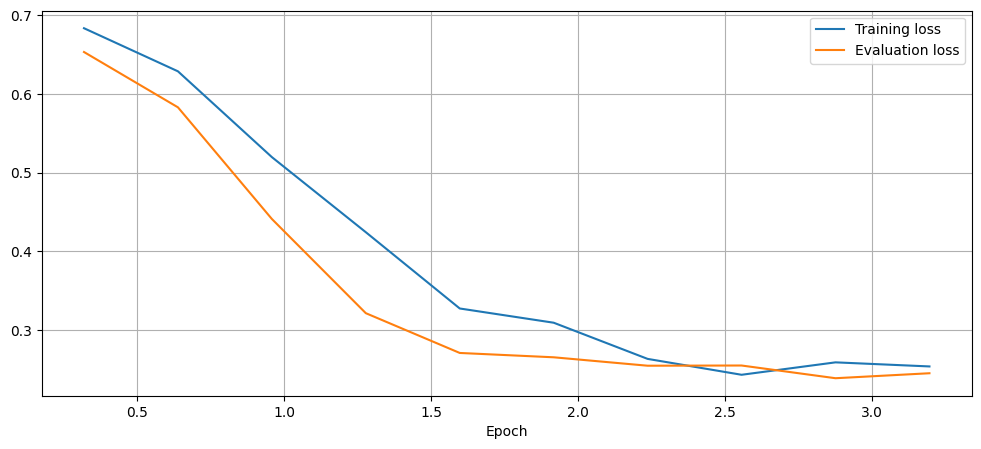

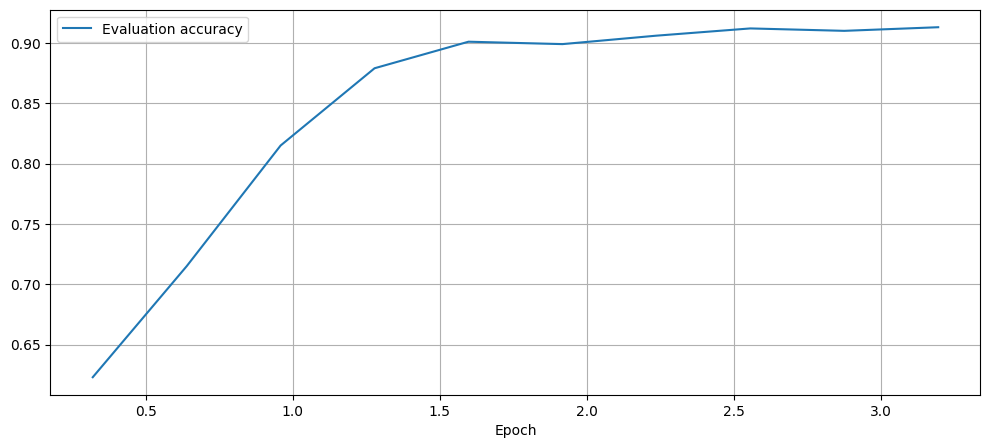

In [32]:
plot(training_logs_bert.logs, ["loss", "eval_loss"], ["Training loss", "Evaluation loss"])
plot(training_logs_bert.logs, ["eval_accuracy"], ["Evaluation accuracy"])

In [33]:
# Get predictions for the test set
test_output = trainer_bert.predict(sampled_dataset_bert["test"])
bert_preds = test_output.predictions.argmax(axis=-1) # These are already argmaxed token IDs

In [34]:
# bert_preds

---

## 6. Fine-tuning a generative model (SmolLM)



### 6.1. Setup

For this, we need to load the model for casual language modeling tasks, so we need to use the `transformsers.AutoModelForCausalLM` API.

Additionally, use  the `transformers.DataCollatorForLanguageModeling` API with mlm to False, because we are formatting the labels to be of the same length as input_ids after tokenization and we will be using -100 to ignore everything except for the output token.

In [35]:
smollm_model = transformers.AutoModelForCausalLM.from_pretrained(SMOLLM)
smollm_tokenizer = transformers.AutoTokenizer.from_pretrained(SMOLLM)
data_collator_smollm = transformers.DataCollatorForLanguageModeling(smollm_tokenizer, mlm=False)

### 6.2 Format and tokenize the dataset

Since we are performing instruction fine-tuning, the dataset needs to be formatted as prompts. As we only care about if the model can correctly predict the next token as the correct label with correct wording, we need to mask the the prompt, so that loss is calculated only on the new generated token.

References:
[Instruction Tuning LLM Discussion](https://discuss.huggingface.co/t/instruction-tuning-llm/67597)

In [36]:
def format_and_tokenize(example):
    token_size = 264
    prompt = get_x_shot_prompt(example["text"], [], 50)
    output = " " + example["label_name"]
    full_text = prompt + output
    
    # 1. Tokenize the full text without padding
    no_padding_full_text_tokenized = smollm_tokenizer(
        smollm_tokenizer.bos_token + full_text,
        add_special_tokens=False
    )
    full_len = len(no_padding_full_text_tokenized["input_ids"])
    
    # 2. Tokenize the prompt alone to find where the answer starts
    prompt_tokenized = smollm_tokenizer(
        smollm_tokenizer.bos_token + prompt,
        add_special_tokens=False
    )
    prompt_len = len(prompt_tokenized["input_ids"])
    
    # 3. Now create the final padded version for the Trainer
    padded_full_text_tokenized = smollm_tokenizer(
        smollm_tokenizer.bos_token + full_text + smollm_tokenizer.eos_token,
        add_special_tokens=False,
        padding="max_length",
        max_length=token_size
    )
    
    # 4. Mask both the PROMPT and the PADDING
    labels = [-100] * token_size
    
    # Only the tokens between prompt_len and full_len are the "answer"
    # These are the only tokens the model should be graded on
    labels[prompt_len:full_len] = padded_full_text_tokenized["input_ids"][prompt_len:full_len]
    
    padded_full_text_tokenized["labels"] = labels
    return padded_full_text_tokenized

In [37]:
sampled_dataset_smollm = sampled_dataset.map(format_and_tokenize)
sampled_dataset_smollm

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 5000
    })
    val: Dataset({
        features: ['text', 'label', 'label_name', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
})

In [38]:
print(max([len(x) for x in sampled_dataset_smollm["train"]["input_ids"]]))
print(max([len(x) for x in sampled_dataset_smollm["train"]["attention_mask"]]))
print(max([len(x) for x in sampled_dataset_smollm["train"]["labels"]]))

print(max([len(x) for x in sampled_dataset_smollm["val"]["input_ids"]]))
print(max([len(x) for x in sampled_dataset_smollm["val"]["attention_mask"]]))
print(max([len(x) for x in sampled_dataset_smollm["val"]["labels"]]))

print(max([len(x) for x in sampled_dataset_smollm["test"]["input_ids"]]))
print(max([len(x) for x in sampled_dataset_smollm["test"]["attention_mask"]]))
print(max([len(x) for x in sampled_dataset_smollm["test"]["labels"]]))

264
264
264
264
264
264
264
264
264


### 6.3 Setup additional functions

Since we are only interested in checking if the model correctly generates "positive" or "negative" and causal/decoder models like SmolLM, generates the next token, we need to define the following compute_accuracy function.

Additionally, we need to define a preprocess_logits_for_metrics function since we do not need the entire predicted vocabs. We only need the argmax to compute accuracy.

In [39]:
def compute_accuracy_causal(eval_preds):
    # Note: These are already argmaxed because of the preprocess_logits function
    # Both are shaped (sample_size, sequence_size)
    predictions, labels = eval_preds
    
    # In Causal LM, the prediction for labels[i] is at predictions[i-1]
    # We shift them so they align
    shift_preds = predictions[:, :-1]
    shift_labels = labels[:, 1:]
    
    # Find indices where we have actual labels (not -100)
    # to evaluate the model on
    valid_positions_mask = shift_labels != -100
    
    # Apply mask to predictions - set invalid positions to 0
    shift_preds = shift_preds * valid_positions_mask
    shift_labels = shift_labels * valid_positions_mask
    
    # Flatten everything
    preds_flat = shift_preds.reshape(-1)
    labels_flat = shift_labels.reshape(-1)
    
    return evaluate.load("accuracy").compute(
        predictions=preds_flat, 
        references=labels_flat
    )

In [40]:
def preprocess_logits_for_metrics(logits, labels):
    """
    Original logits are (batch_size, sequence_length, vocab_size)
    We only need the argmax (the predicted token ID) to compute accuracy.
    """
    if isinstance(logits, tuple):
        # Some models return a tuple (logits, past_key_values)
        logits = logits[0]
    
    # Return the index of the max logit (predicted token ID)
    return logits.argmax(dim=-1)

### 6.4 SmolLM hyperparameter optimization and training

In [41]:
trainer_args_smollm = transformers.TrainingArguments(
    "checkpoints/smollm",
    eval_strategy="steps",
    logging_strategy="steps",
    load_best_model_at_end=True,
    eval_steps=100,
    logging_steps=100,
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=4,
    max_steps=1000,
    bf16=True,
    optim="adamw_torch_fused",
    report_to="none",
)

training_logs_smollm = LogSavingCallback()

In [42]:
trainer_smollm = transformers.Trainer(
    model=smollm_model,
    args=trainer_args_smollm,
    train_dataset=sampled_dataset_smollm["train"],
    eval_dataset=sampled_dataset_smollm["val"],
    compute_metrics=compute_accuracy_causal,
    data_collator=data_collator_smollm,
    tokenizer=smollm_tokenizer,
    callbacks=[early_stopping, training_logs_smollm],
    preprocess_logits_for_metrics=preprocess_logits_for_metrics
)

trainer_smollm.train()

/tmp/ipykernel_77727/1952469741.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_smollm = transformers.Trainer(


Step,Training Loss,Validation Loss,Accuracy
100,2.051700,1.897326,0.832456
200,1.869500,1.875379,0.833650
300,1.860400,1.864183,0.834384
400,1.766400,1.862012,0.834897
500,1.732200,1.859541,0.834951
600,1.737900,1.855205,0.835335
700,1.687900,1.863167,0.835217
800,1.666800,1.861845,0.835297
900,1.669600,1.861223,0.835392
1000,1.646000,1.862440,0.835388


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=1000, training_loss=1.7688540649414062, metrics={'train_runtime': 722.3889, 'train_samples_per_second': 22.149, 'train_steps_per_second': 1.384, 'total_flos': 2687582958280704.0, 'train_loss': 1.7688540649414062, 'epoch': 3.1952})

### 6.5. Evaluation on test set

In [43]:
eval_results_smollm = trainer_smollm.evaluate(
    sampled_dataset_smollm["test"]
)

pprint(eval_results_smollm)

print('Accuracy:', eval_results_smollm['eval_accuracy'])

{'epoch': 3.1952,
 'eval_accuracy': 0.8353688212927757,
 'eval_loss': 1.8438383340835571,
 'eval_runtime': 13.5822,
 'eval_samples_per_second': 73.626,
 'eval_steps_per_second': 18.406}
Accuracy: 0.8353688212927757


In [44]:
# Get predictions for the test set
test_output = trainer_smollm.predict(sampled_dataset_smollm["test"])
preds = test_output.predictions # These are already argmaxed token IDs

In [45]:
pred_decodes = []

for i in range(len(preds)):
    # Get the label IDs for this example
    labels = sampled_dataset_smollm["test"][i]["labels"]
    
    # Find where the label (the answer) starts
    label_start_idx = next(idx for idx, val in enumerate(labels) if val != -100)
    
    # Predict at [start - 1] because of the causal shift
    pred = preds[i][label_start_idx - 1]
    pred_decodes.append(smollm_tokenizer.decode([pred]))

show_results(pred_decodes, sampled_dataset_smollm["test"]["label_name"][:])

Valid Labeling: 1000/1000
Valid Sentiment Accuracy: 79.80%
Valid Sentiment Label Name Accuracy: 79.80%
Tokens generated by the model: {'negative', 'positive'}


/tmp/ipykernel_77727/1871616770.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


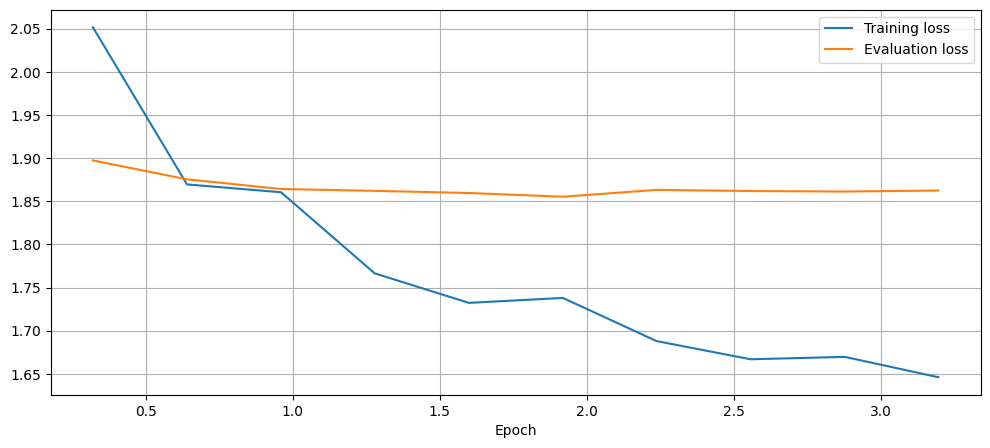

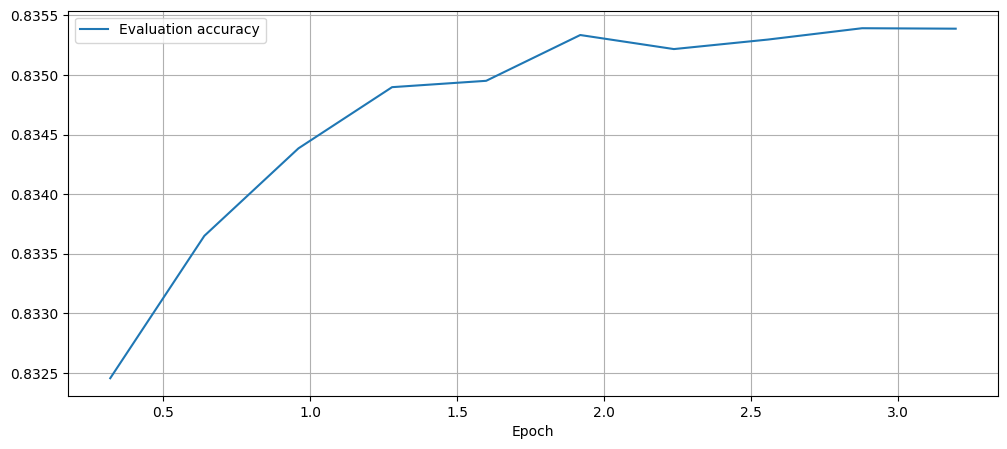

In [46]:
plot(training_logs_smollm.logs, ["loss", "eval_loss"], ["Training loss", "Evaluation loss"])
plot(training_logs_smollm.logs, ["eval_accuracy"], ["Evaluation accuracy"])

### 7 Results & Error Analysis

Among the trained models, BERT model performed best for the given instructions! The model had an accuracy of 87.2% in the test set. For the Few shot prompts the accuracy of the SmolLM model was only 69.4% This was because the model was trying to label the as positive, negative or neutral. But as the data is highly polar, the response were incorrect. In the case of finetunned SmolLM, We achieved an accuracy of 79.8% for our instruction. Originally we found the best result for this model approach at max_step 500. But we wanted to see if it becomes flatlined if we double it. However the accuracy and the training and Evaluation loss stayed the same/similar, regardless.

Four-shot propting with SmolLM did well after fine-tuning the prompt to make it follow the exact output format. Previously, it's prediction generated several tokens which were close to the sentiment.

Instruction fine-tuning for SmolLM was particularly challenging. This required formatting the dataset with instruction - review - response format and introduce manual label masking. Furthermore, accuracy function with preprocessing logits were also needed to be tweaked as for the former, generative models' prediction for ith token is for the label i+1 and the later function was needed to offload to prevent unnecessary memory usage by only sending the argmax vocab of the predictions.

Since, we are only interested in the final predicted output and if it followed the exact instruction, fine-tuning approach likely had lower accuracy simply because it may have predicted similar tokens for the labels. The loss were likely high because it compared with all the tokens in an example.

In [70]:
# Bert
bert_test_output = trainer_bert.predict(sampled_dataset_bert["test"])
bert_preds = bert_test_output.predictions.argmax(axis=-1)

In [71]:
# smollm few-shot
smollm_fewshot_preds = []
pos_tokens = ["pos", "positive", "good", "correct", "1"]
neg_tokens = ["neg", "negative", "bad", "incorrect", "0"]

In [72]:
for r in responses:
    lowercased = r.strip().lower()
    if lowercased in pos_tokens:
        smollm_fewshot_preds.append(1)
    elif lowercased in neg_tokens:
        smollm_fewshot_preds.append(0)
    else:
        smollm_fewshot_preds.append(-1)  # Invalid format

In [73]:
smollm_finetuned_preds = []
for pred in pred_decodes:
    lowercased = pred.strip().lower()
    if lowercased in pos_tokens:
        smollm_finetuned_preds.append(1)
    elif lowercased in neg_tokens:
        smollm_finetuned_preds.append(0)
    else:
        smollm_finetuned_preds.append(-1)  # Invalid format

In [74]:
true_labels = sampled_dataset["test"]["label"]

# 2. Categorize predictions
all_correct = []
all_wrong = []
one_correct = []
two_correct = []
format_errors_fewshot = []
format_errors_finetuned = []

In [75]:
for i in range(len(true_labels)):
    true_label = true_labels[i]
    bert_correct = (bert_preds[i] == true_label)
    fewshot_correct = (smollm_fewshot_preds[i] == true_label)
    finetuned_correct = (smollm_finetuned_preds[i] == true_label)
    
    # Track format errors
    if smollm_fewshot_preds[i] == -1:
        format_errors_fewshot.append(i)
    if smollm_finetuned_preds[i] == -1:
        format_errors_finetuned.append(i)
    
    correct_count = sum([bert_correct, fewshot_correct, finetuned_correct])
    
    if correct_count == 3:
        all_correct.append(i)
    elif correct_count == 0:
        all_wrong.append(i)
    elif correct_count == 1:
        one_correct.append(i)
    elif correct_count == 2:
        two_correct.append(i)

In [76]:
# 3. Print summary statistics

print(f"\nTotal test examples: {len(true_labels)}")
print(f"  All three correct:           {len(all_correct):4d} ({100*len(all_correct)/len(true_labels):5.2f}%)")
print(f"  All three wrong:             {len(all_wrong):4d} ({100*len(all_wrong)/len(true_labels):5.2f}%)")
print(f"  Exactly one correct:         {len(one_correct):4d} ({100*len(one_correct)/len(true_labels):5.2f}%)")
print(f"  Exactly two correct:         {len(two_correct):4d} ({100*len(two_correct)/len(true_labels):5.2f}%)")

print(f"\nGenerative Model Format Issues:")
print(f"  SmolLM (Few-shot) format errors:  {len(format_errors_fewshot):4d} ({100*len(format_errors_fewshot)/len(true_labels):5.2f}%)")
print(f"  SmolLM (Fine-tuned) format errors: {len(format_errors_finetuned):4d} ({100*len(format_errors_finetuned)/len(true_labels):5.2f}%)")


Total test examples: 1000
  All three correct:            544 (54.40%)
  All three wrong:               40 ( 4.00%)
  Exactly one correct:          118 (11.80%)
  Exactly two correct:          298 (29.80%)

Generative Model Format Issues:
  SmolLM (Few-shot) format errors:    26 ( 2.60%)
  SmolLM (Fine-tuned) format errors:    0 ( 0.00%)


Comparison between the models:

From here We can see that among the 1000 resampled reviews from the test set, All models got 54.4%(544) correct.All three were wrong in only 40 classification tasks. But only 1 model predicted correctly 118 times, but 298 times at least 2 models predicted correctly.


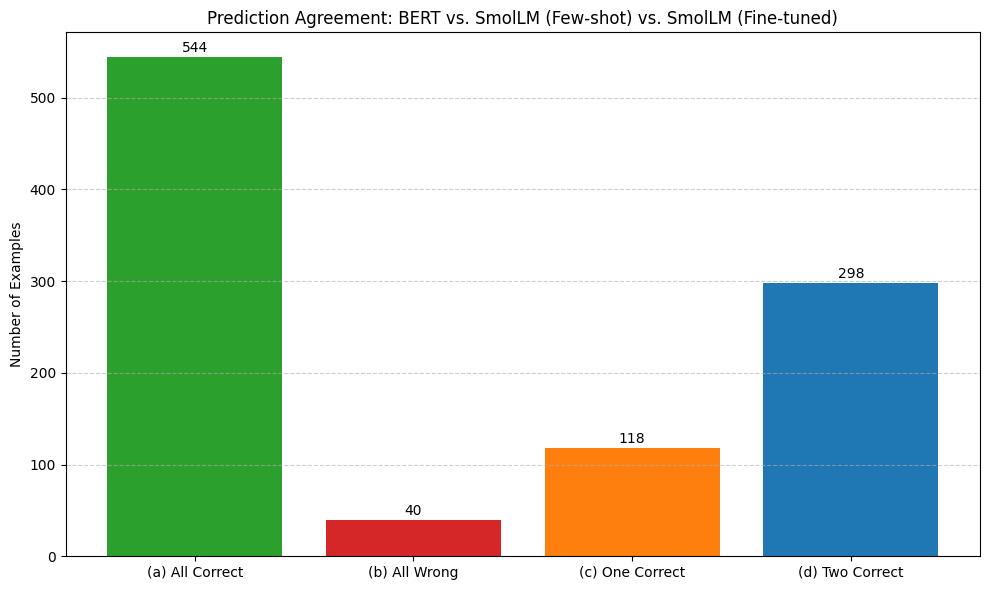

In [77]:
plt.figure(figsize=(10, 6))
categories = ['(a) All Correct', '(b) All Wrong', '(c) One Correct', '(d) Two Correct']
counts = [len(all_correct), len(all_wrong), len(one_correct), len(two_correct)]
colors = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']

bars = plt.bar(categories, counts, color=colors)
plt.title('Prediction Agreement: BERT vs. SmolLM (Few-shot) vs. SmolLM (Fine-tuned)', fontsize=12)
plt.ylabel('Number of Examples')
plt.grid(axis='y', linestyle='--', alpha=0.6)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 2, f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [78]:
fewshot_format_errors = 0
fewshot_semantic_errors = 0
finetuned_format_errors = 0
finetuned_semantic_errors = 0

In [79]:
for i in range(len(true_labels)):
    true_label = true_labels[i]
    
    # Few-shot analysis
    if smollm_fewshot_preds[i] == -1:
        fewshot_format_errors += 1
    elif smollm_fewshot_preds[i] != true_label:
        fewshot_semantic_errors += 1
    
    # Fine-tuned analysis
    if smollm_finetuned_preds[i] == -1:
        finetuned_format_errors += 1
    elif smollm_finetuned_preds[i] != true_label:
        finetuned_semantic_errors += 1

In [ ]:
print(f"\nSmolLM (Few-shot) Errors:")
print(f"Format errors (invalid output):   {fewshot_format_errors}")
print(f"Semantic errors (wrong label):    {fewshot_semantic_errors}")
print(f"Total errors:                     {fewshot_format_errors + fewshot_semantic_errors}")

print(f"\nSmolLM (Fine-tuned) Errors:")
print(f"Format errors (invalid output):   {finetuned_format_errors}")
print(f"Semantic errors (wrong label):    {finetuned_semantic_errors}")
print(f"otal errors:                     {finetuned_format_errors + finetuned_semantic_errors}")



SmolLM (Few-shot) Errors:
Format errors (invalid output):   26
Semantic errors (wrong label):    298
Total errors:                     324

SmolLM (Fine-tuned) Errors:
Format errors (invalid output):   0
Semantic errors (wrong label):    202
otal errors:                     202


It seems that the smolLM produces a small number of invalid responeses. But for both models, mostly the accuracy falls due to wrong labels. Generative models might responded with more than 1 token to label. In this case even if the sentiment is correct, the format is invalid and the model failed to follow the instruction properly.

### Corpus information


The imdb dataset is a large movie review dataset which is used for sentiment classification of the reviews. The dataset contains 25000 highly polar reviews with for training and 25000 for testing. The labels are neg(0) or pos (1). This dataset was first introduced in 2011 as the best dataset for such a high number of polar reviews and labels. Recently this corpus was used in evaluating LLMs classic sentiment benchmarking. in this specific study, the Doubao pro LLM performed the best with an accuracy of 74% with this corpus.  The random baseline performance is 50% for this corpus.

## References

* **Maas et al. (2011):** [Learning Word Vectors for Sentiment Analysis](http://www.aclweb.org/anthology/P11-1015).  
    *Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics.*

* **Zhang et al. (2024):** [Large Language Models for Sentiment Analysis: A Survey and Comparative Study] (arXiv preprint arXiv:2409.02370)
